### Finding the best finishers in football for the last 12 years

#### Importing necessary packages for bayesian analysis, data analysis and visualization:

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
plt.style.use('bmh')
plt.rcParams['font.family'] = 'serif'
import re
import scipy.stats as stats
from scipy.special import btdtri
from scipy.stats import chi2_contingency as chi_sq

#### Getting data and cleaning it for analysis:

In [2]:
# prepare data for analysis
def read_and_process_data(filename):
    # read in file
    data = pd.read_csv(filename, header = None, encoding='utf-8')
    
    # keep only top 5 leagues
    top5=['english+premier+league','french+ligue+1','italian+serie+a','german+bundesliga','spanish+primera+división']
    data = data[data[2].apply(lambda x: x in top5)]
    
    # keep columns event and player
    data = data.iloc[:, [15, 17]]
    data.columns = ['Event', 'Player']
    data['Event'] = data['Event'].astype(str)
    
    # extract event name from column
    data['Event'] = data['Event'].apply(lambda x: list(reversed(x.split('<br>')))[0])
    
    # remove penalties
    data = data[data['Event'].apply(lambda x: 'Penalty' not in x)]
    
    # remove nans
    data = data[data['Event'] != 'nan']
    
    # remove own goals
    data = data[data.Event != 'Own Goal']
    
    # convert column to goal or not
    data['Event'] = data['Event'].apply(lambda x: 'Goal' in x).astype(int)
    
    # extract player name from column
    data['Player'] = data['Player'].astype(str)
    data['Player'] = data['Player'].apply(lambda x: list(reversed(x.split('by ')))[0])
    data['Player'] = data['Player'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    
    # rename columns
    data.columns = ['Goal', 'Player']
    
    # get conversion rate and total shots for each player
    data = data.groupby('Player')['Goal'].agg(['mean', 'count', 'sum']).reset_index()
    
    # rename columns of aggregated data
    data.columns = ['Player', 'Conversion Rate', 'Shots', 'Scored']
    
    # add missed column
    data['Missed'] = data['Shots'] - data['Scored']
    
    # return sorted data
    data = data.sort_values('Shots', ascending = False)
    
    return data

# save processed data to a file
# data = read_and_process_data('shots.csv')
# data.to_csv('data.csv', index = False)

# read in processed file
data = pd.read_csv('data.csv')

#### Some exploratory visualizations of the data:

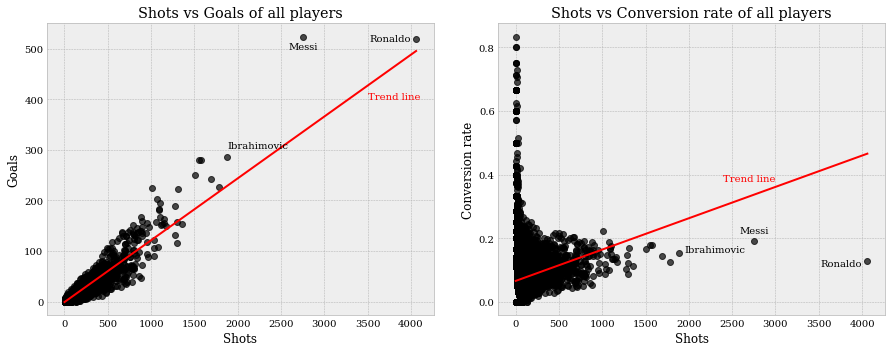

In [3]:
# EDA
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))

ax1.set_title('Shots vs Goals of all players')
ax1.set_xlabel('Shots')
ax1.set_ylabel('Goals')
ax1.plot(data['Shots'], data['Scored'], 'ko', alpha = 0.7)
z = np.polyfit(data['Shots'], data['Scored'], 1)
p = np.poly1d(z)
ax1.plot(data['Shots'], p(data['Shots']), 'r')
ax1.text(3500, 400, 'Trend line', color = 'r')
ax1.text(2756, 500, 'Messi', horizontalalignment = 'center')
ax1.text(4000, 519, 'Ronaldo', horizontalalignment = 'right', verticalalignment = 'center')
ax1.text(1883, 300, 'Ibrahimovic', horizontalalignment = 'left', verticalalignment = 'bottom')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')

shots = data['Shots'][data['Conversion Rate'] != 1]
cr = data['Conversion Rate'][data['Conversion Rate'] != 1]
ax2.set_title('Shots vs Conversion rate of all players')
ax2.set_xlabel('Shots')
ax2.set_ylabel('Conversion rate')
ax2.plot(shots, cr, 'ko', alpha = 0.7)
z = np.polyfit(shots, cr, 1)
p = np.poly1d(z)
ax2.plot(shots, p(shots), 'r')
ax2.text(3000, 0.4, 'Trend line', color = 'r', verticalalignment = 'top', horizontalalignment = 'right')
ax2.text(2756, 0.21, 'Messi', horizontalalignment = 'center', verticalalignment = 'bottom')
ax2.text(4000, 0.12, 'Ronaldo', horizontalalignment = 'right', verticalalignment = 'center')
ax2.text(1950, 0.15, 'Ibrahimovic', horizontalalignment = 'left', verticalalignment = 'bottom')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')

plt.subplots_adjust(wspace = 1.5)
fig.tight_layout()

#### Fitting a prior beta distribution to conversion rates of players with 200+ shots:

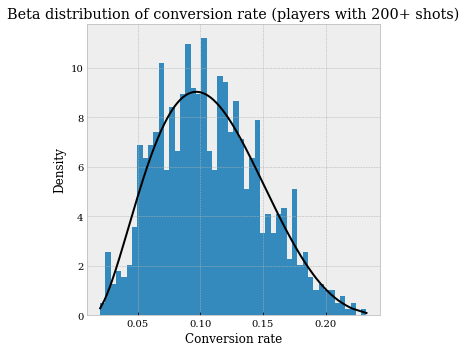

In [4]:
# beta fit to all players conversion rates with 200+ shots
cv_above200 = sorted(data['Conversion Rate'][data['Shots'] > 200])
fig, ax = plt.subplots(figsize = (6, 5))
ax.set_title('Beta distribution of conversion rate (players with 200+ shots)')
ax.set_xlabel('Conversion rate')
ax.set_ylabel('Density')
ax.hist(cv_above200, bins = 50, density = True, label = 'converstion rate')
prior = stats.beta.fit(cv_above200)
ax.plot(cv_above200, stats.beta.pdf(cv_above200, prior[0], prior[1], prior[2], prior[3]), 'k', label = 'beta')
ax.yaxis.set_ticks_position('none')
fig.tight_layout()

#### Updating the prior using every players goals and shots information:

In [5]:
# calculate the scaled values of a and b since beta fit gives normalised values
prior_m, prior_v = stats.beta.stats(prior[0], prior[1], prior[2], prior[3])
prior_a = prior_m / prior_v
prior_b = (1 - prior_m) / prior_v

# update a and b for all players
posterior_a_values = prior_a + data['Scored']
posterior_b_values = prior_b + data['Missed']
data['Posterior a'] = posterior_a_values
data['Posterior b'] = posterior_b_values

# calculate posterior parameters for all players
posterior_means = stats.beta.stats(posterior_a_values, posterior_b_values, moments = 'm')
data['Posterior Conversion Rate'] = posterior_means

#### Visualizing the difference in conversion rates after calculating the posteriors:

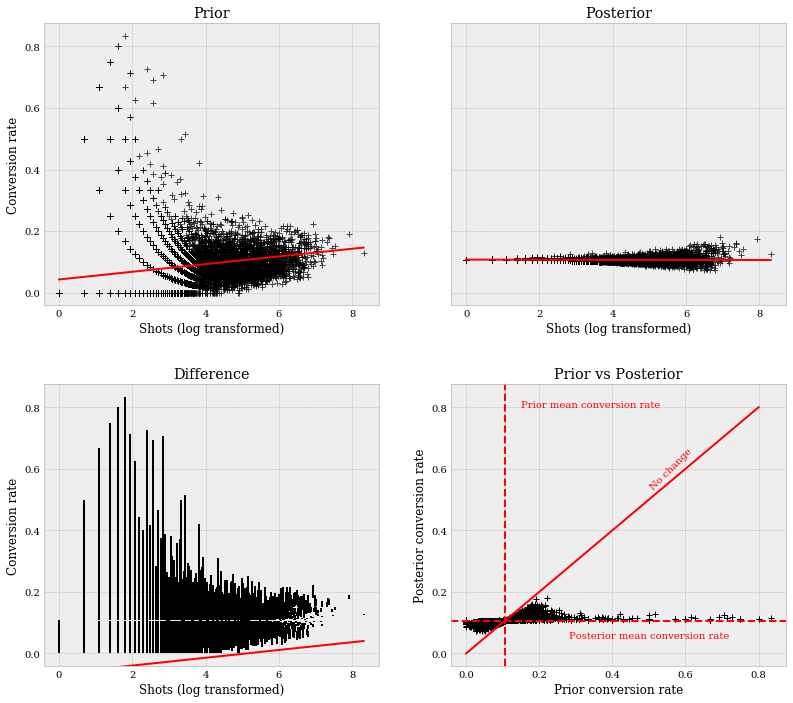

In [6]:
# before and after conversion rates
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10))
ax1, ax2, ax3, ax4 = ax.flatten()

ax1.set_title('Prior')
ax1.set_xlabel('Shots (log transformed)')
ax1.set_ylabel('Conversion rate')
shots_transformed = np.log(data['Shots'][data['Conversion Rate'] != 1])
conversion_rates = data['Conversion Rate'][data['Conversion Rate'] != 1]
ax1.plot(shots_transformed, conversion_rates, 'k+', alpha = 0.7)
z = np.polyfit(shots_transformed, conversion_rates, 1)
p = np.poly1d(z)
ax1.plot(shots_transformed, p(shots_transformed), 'r')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')

ax2.set_title('Posterior')
ax2.set_xlabel('Shots (log transformed)')
ax2.plot(shots_transformed, posterior_means[data['Conversion Rate'] != 1], 'k+', alpha = 0.7)
z = np.polyfit(shots_transformed, posterior_means[data['Conversion Rate'] != 1], 1)
p = np.poly1d(z)
ax2.plot(shots_transformed, p(shots_transformed), 'r')
ax2.set_ylim(ax1.get_ylim())
ax2.yaxis.set_ticklabels([])
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')

ax3.set_title('Difference')
ax3.set_xlabel('Shots (log transformed)')
ax3.set_ylabel('Conversion rate')
ax3.vlines(x = shots_transformed, ymin = posterior_means[data['Conversion Rate'] != 1], ymax = conversion_rates)
z = np.polyfit(shots_transformed, conversion_rates - posterior_means[data['Conversion Rate'] != 1], 1)
p = np.poly1d(z)
ax3.plot(shots_transformed, p(shots_transformed), 'r')
ax3.set_ylim(ax1.get_ylim())
ax3.xaxis.set_ticks_position('none')
ax3.yaxis.set_ticks_position('none')

ax4.set_title('Prior vs Posterior')
ax4.set_xlabel('Prior conversion rate')
ax4.set_ylabel('Posterior conversion rate')
ax4.plot(conversion_rates, posterior_means[data['Conversion Rate'] != 1], 'k+')
ax4.plot([0, 0.8], [0, 0.8], color = 'red')
ax4.text(0.5, 0.65, 'No change', color = 'r', horizontalalignment = 'left', rotation = 45)
ax4.axvline(x = prior_m, linestyle = '--', color = 'red')
ax4.text(0.15, 0.8, 'Prior mean conversion rate', color = 'r', horizontalalignment = 'left')
ax4.axhline(y = np.mean(data['Posterior Conversion Rate']), linestyle = '--', color = 'red')
ax4.text(0.5, 0.05, 'Posterior mean conversion rate', color = 'r', horizontalalignment = 'center')
ax4.set_ylim(ax1.get_ylim())
ax4.xaxis.set_ticks_position('none')
ax4.yaxis.set_ticks_position('none')

plt.subplots_adjust(wspace = 5)
plt.subplots_adjust(hspace = 5)
fig.tight_layout()

#### Comparing posteriors of some well known players:

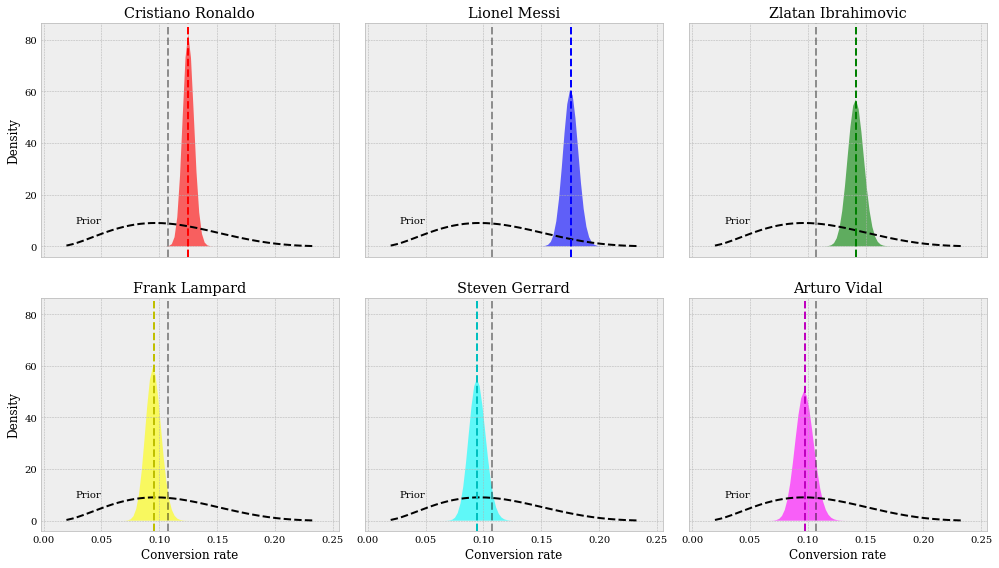

In [7]:
# posterior distributions of some players
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (14, 8))
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()

ax1.set_title('Cristiano Ronaldo')
ax1.set_ylabel('Density')
prior = stats.beta.fit(cv_above200)
ax1.plot(cv_above200, stats.beta.pdf(cv_above200, prior[0], prior[1], prior[2], prior[3]), 'k--', label = 'beta')
ax1.text(0.05, 10, 'Prior', color = 'k', verticalalignment = 'center', horizontalalignment = 'right')
x_dummies = np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 100)
ronaldo_a = data['Posterior a'][data['Player'] == 'Cristiano Ronaldo'].values[0]
ronaldo_b = data['Posterior b'][data['Player'] == 'Cristiano Ronaldo'].values[0]
ronaldo_beta = stats.beta.pdf(x_dummies, ronaldo_a, ronaldo_b)
ax1.fill_between(x_dummies, ronaldo_beta, facecolor = 'red', alpha = 0.6)
ax1.axvline(x = prior_m, linestyle = '--', color = 'k', alpha = 0.4)
ronaldo_mean = data['Posterior Conversion Rate'][data['Player'] == 'Cristiano Ronaldo'].values[0]
ax1.axvline(x = ronaldo_mean, linestyle = '--', color = 'r')
ax1.xaxis.set_ticklabels([])
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')

ax2.set_title('Lionel Messi')
ax2.plot(cv_above200, stats.beta.pdf(cv_above200, prior[0], prior[1], prior[2], prior[3]), 'k--', label = 'beta')
ax2.text(0.05, 10, 'Prior', color = 'k', verticalalignment = 'center', horizontalalignment = 'right')
x_dummies = np.linspace(ax2.get_xlim()[0], ax2.get_xlim()[1], 100)
messi_a = data['Posterior a'][data['Player'] == 'Lionel Messi'].values[0]
messi_b = data['Posterior b'][data['Player'] == 'Lionel Messi'].values[0]
messi_beta = stats.beta.pdf(x_dummies, messi_a, messi_b)
ax2.fill_between(x_dummies, messi_beta, facecolor = 'blue', alpha = 0.6)
ax2.axvline(x = prior_m, linestyle = '--', color = 'k', alpha = 0.4)
messi_mean = data['Posterior Conversion Rate'][data['Player'] == 'Lionel Messi'].values[0]
ax2.axvline(x = messi_mean, linestyle = '--', color = 'b')
ax2.set_ylim(ax1.get_ylim())
ax2.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')

ax3.set_title('Zlatan Ibrahimovic')
ax3.plot(cv_above200, stats.beta.pdf(cv_above200, prior[0], prior[1], prior[2], prior[3]), 'k--', label = 'beta')
ax3.text(0.05, 10, 'Prior', color = 'k', verticalalignment = 'center', horizontalalignment = 'right')
x_dummies = np.linspace(ax3.get_xlim()[0], ax3.get_xlim()[1], 100)
ibra_a = data['Posterior a'][data['Player'] == 'Zlatan Ibrahimovic'].values[0]
ibra_b = data['Posterior b'][data['Player'] == 'Zlatan Ibrahimovic'].values[0]
ibra_beta = stats.beta.pdf(x_dummies, ibra_a, ibra_b)
ax3.fill_between(x_dummies, ibra_beta, facecolor = 'green', alpha = 0.6)
ax3.axvline(x = prior_m, linestyle = '--', color = 'k', alpha = 0.4)
ibra_mean = data['Posterior Conversion Rate'][data['Player'] == 'Zlatan Ibrahimovic'].values[0]
ax3.axvline(x = ibra_mean, linestyle = '--', color = 'g')
ax3.set_ylim(ax1.get_ylim())
ax3.xaxis.set_ticklabels([])
ax3.yaxis.set_ticklabels([])
ax3.xaxis.set_ticks_position('none')
ax3.yaxis.set_ticks_position('none')

ax4.set_title('Frank Lampard')
ax4.set_xlabel('Conversion rate')
ax4.set_ylabel('Density')
ax4.plot(cv_above200, stats.beta.pdf(cv_above200, prior[0], prior[1], prior[2], prior[3]), 'k--', label = 'beta')
ax4.text(0.05, 10, 'Prior', color = 'k', verticalalignment = 'center', horizontalalignment = 'right')
x_dummies = np.linspace(ax4.get_xlim()[0], ax4.get_xlim()[1], 100)
lamp_a = data['Posterior a'][data['Player'] == 'Frank Lampard'].values[0]
lamp_b = data['Posterior b'][data['Player'] == 'Frank Lampard'].values[0]
lamp_beta = stats.beta.pdf(x_dummies, lamp_a, lamp_b)
ax4.fill_between(x_dummies, lamp_beta, facecolor = 'yellow', alpha = 0.6)
ax4.axvline(x = prior_m, linestyle = '--', color = 'k', alpha = 0.4)
lamp_mean = data['Posterior Conversion Rate'][data['Player'] == 'Frank Lampard'].values[0]
ax4.axvline(x = lamp_mean, linestyle = '--', color = 'y')
ax4.set_ylim(ax1.get_ylim())
ax4.yaxis.set_ticks_position('none')
ax4.xaxis.set_ticks_position('none')

ax5.set_title('Steven Gerrard')
ax5.set_xlabel('Conversion rate')
ax5.plot(cv_above200, stats.beta.pdf(cv_above200, prior[0], prior[1], prior[2], prior[3]), 'k--', label = 'beta')
ax5.text(0.05, 10, 'Prior', color = 'k', verticalalignment = 'center', horizontalalignment = 'right')
x_dummies = np.linspace(ax5.get_xlim()[0], ax5.get_xlim()[1], 100)
sg_a = data['Posterior a'][data['Player'] == 'Steven Gerrard'].values[0]
sg_b = data['Posterior b'][data['Player'] == 'Steven Gerrard'].values[0]
sg_beta = stats.beta.pdf(x_dummies, sg_a, sg_b)
ax5.fill_between(x_dummies, sg_beta, facecolor = 'cyan', alpha = 0.6)
ax5.axvline(x = prior_m, linestyle = '--', color = 'k', alpha = 0.4)
sg_mean = data['Posterior Conversion Rate'][data['Player'] == 'Steven Gerrard'].values[0]
ax5.axvline(x = sg_mean, linestyle = '--', color = 'c')
ax5.set_ylim(ax1.get_ylim())
ax5.yaxis.set_ticklabels([])
ax5.xaxis.set_ticks_position('none')
ax5.yaxis.set_ticks_position('none')

ax6.set_title('Arturo Vidal')
ax6.set_xlabel('Conversion rate')
ax6.plot(cv_above200, stats.beta.pdf(cv_above200, prior[0], prior[1], prior[2], prior[3]), 'k--', label = 'beta')
ax6.text(0.05, 10, 'Prior', color = 'k', verticalalignment = 'center', horizontalalignment = 'right')
x_dummies = np.linspace(ax6.get_xlim()[0], ax6.get_xlim()[1], 100)
av_a = data['Posterior a'][data['Player'] == 'Arturo Vidal'].values[0]
av_b = data['Posterior b'][data['Player'] == 'Arturo Vidal'].values[0]
av_beta = stats.beta.pdf(x_dummies, av_a, av_b)
ax6.fill_between(x_dummies, av_beta, facecolor = 'magenta', alpha = 0.6)
ax6.axvline(x = prior_m, linestyle = '--', color = 'k', alpha = 0.4)
av_mean = data['Posterior Conversion Rate'][data['Player'] == 'Arturo Vidal'].values[0]
ax6.axvline(x = av_mean, linestyle = '--', color = 'm')
ax6.set_ylim(ax1.get_ylim())
ax6.yaxis.set_ticklabels([])
ax6.yaxis.set_ticks_position('none')
ax6.xaxis.set_ticks_position('none')
ax6.yaxis.set_ticks_position('none')

plt.subplots_adjust(hspace = 20)
fig.tight_layout()

#### Caculating credible intervals (errors in our estimates of the priors):

In [8]:
# calculating 95% credible intervals for posterior
data['Cred 0.025th'] = btdtri(data['Posterior a'], data['Posterior b'], 0.025)
data['Cred 0.975th'] = btdtri(data['Posterior a'], data['Posterior b'], 0.975)

# players with highest conversion rate with shots above 1500
top_players_above_1500 = data[data['Shots'] > 1500].sort_values('Posterior Conversion Rate', ascending = False)
top_players_above_1500.reset_index(inplace = True, drop = True)

#### Visualizaing estimates along with credible intervals for top 8 finishers:

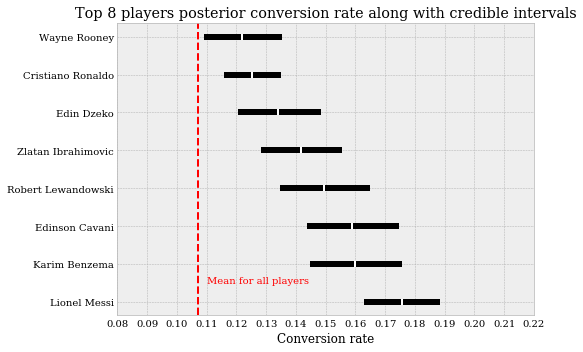

In [9]:
# top 8 players posterior along with credible intervals
lower_error = top_players_above_1500['Posterior Conversion Rate'] - top_players_above_1500['Cred 0.025th']
upper_error = top_players_above_1500['Cred 0.975th'] - top_players_above_1500['Posterior Conversion Rate']
conversion_rates = top_players_above_1500['Posterior Conversion Rate']
fig, ax = plt.subplots(figsize = (8, 5))
ax.set_title('Top 8 players posterior conversion rate along with credible intervals')
ax.set_xlabel('Conversion rate')
ax.errorbar(y = top_players_above_1500['Player'], x = conversion_rates,
            xerr = [lower_error, upper_error],
            markeredgewidth = 2, fmt = 'w|', ecolor = 'black', elinewidth = 6)
ax.axvline(x = np.mean(data['Posterior Conversion Rate']), linestyle = '--', color = 'r')
ax.set_xlim([0.08, 0.22])
ax.text(0.11, 0.5, 'Mean for all players', color = 'r')
plt.xticks(np.arange(0.08, 0.22, 0.01))
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
fig.tight_layout()

#### Chi-sqaured test for comparison of Cavani's and Ibrahimovic's conversion rates:

In [10]:
# chi-sqaure test for independence
zi_scored = data.loc[data['Player'] == 'Zlatan Ibrahimovic', 'Scored'].values[0]
zi_missed = data.loc[data['Player'] == 'Zlatan Ibrahimovic', 'Missed'].values[0]
ec_scored = data.loc[data['Player'] == 'Edinson Cavani', 'Scored'].values[0]
ec_missed = data.loc[data['Player'] == 'Edinson Cavani', 'Missed'].values[0]
table = np.array([[zi_scored, zi_missed], [ec_scored, ec_missed]])
p_value = chi_sq(table)[1]
print('p-value for chi-square test is ' + str(round(p_value, 3)) + ', which is less than the critical value of 0.05.')
print('Hence the data says that Cavani is a better finisher than Ibrahimovic.')

p-value for chi-square test is 0.045, which is less than the critical value of 0.05.
Hence the data says that Cavani is a better finisher than Ibrahimovic.


In [11]:
# simulation from posteriors
# cavani
ec_a = data.loc[data['Player'] == 'Edinson Cavani', 'Posterior a']
ec_b = data.loc[data['Player'] == 'Edinson Cavani', 'Posterior b']
ec_posterior_sim = np.random.beta(ec_a, ec_b, 50000)

# ibra
zi_a = data.loc[data['Player'] == 'Zlatan Ibrahimovic', 'Posterior a']
zi_b = data.loc[data['Player'] == 'Zlatan Ibrahimovic', 'Posterior b']
zi_posterior_sim = np.random.beta(zi_a, zi_b, 50000)

# probability that cavani > lewandowski
pCz = np.mean(ec_posterior_sim > zi_posterior_sim)
print('Probability that Cavani is a better finisher than Ibrahimovic: ' + str(pCz))

Probability that Cavani is a better finisher than Ibrahimovic: 0.9481


#### Plotting joint distribution of Cavani's and Ibrahimovic's posteriors:

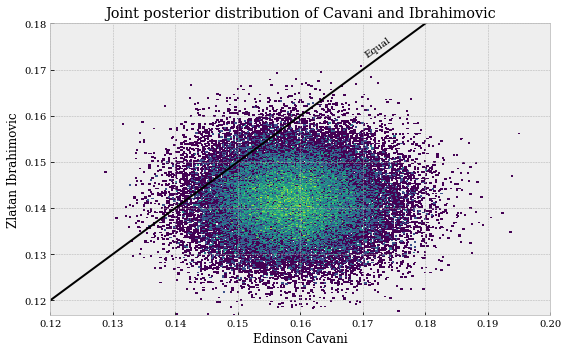

In [12]:
# joint distribution of cavani and ibrahimovic
fig, ax = plt.subplots(figsize = (8, 5))
ax.set_title('Joint posterior distribution of Cavani and Ibrahimovic')
ax.set_xlabel('Edinson Cavani')
ax.set_ylabel('Zlatan Ibrahimovic')
ax.hist2d(ec_posterior_sim, zi_posterior_sim, bins = 300, norm = colors.LogNorm())
ax.set_xlim([0.12, 0.20])
ax.set_ylim(top = 0.18)
ax.plot([0.12, 0.20], [0.12, 0.20], color = 'black')
ax.text(0.17, 0.176, 'Equal', rotation = 35)
ax.grid()
fig.tight_layout()

#### Taking number of shots into consideration to use different priors for all players:

In [13]:
# adjusted priors for all players
adjusted_prior_m = prior_m + (data['Shots'] - np.mean(data['Shots'])) / np.var(data['Shots'])
adjusted_prior_a = adjusted_prior_m / prior_v
adjusted_prior_b = (1 - adjusted_prior_m) / prior_v

# update a and b for all players
adjusted_posterior_a_values = adjusted_prior_a + data['Scored']
adjusted_posterior_b_values = adjusted_prior_b + data['Missed']
data['Adjusted Posterior a'] = adjusted_posterior_a_values
data['Adjusted Posterior b'] = adjusted_posterior_b_values

# calculate posterior parameters for all players
adjusted_posterior_means = stats.beta.stats(adjusted_posterior_a_values, adjusted_posterior_b_values, moments = 'm')
data['Adjusted Posterior Conversion Rate'] = adjusted_posterior_means

#### Visualizing the posterior conversion rate after updating priors again:

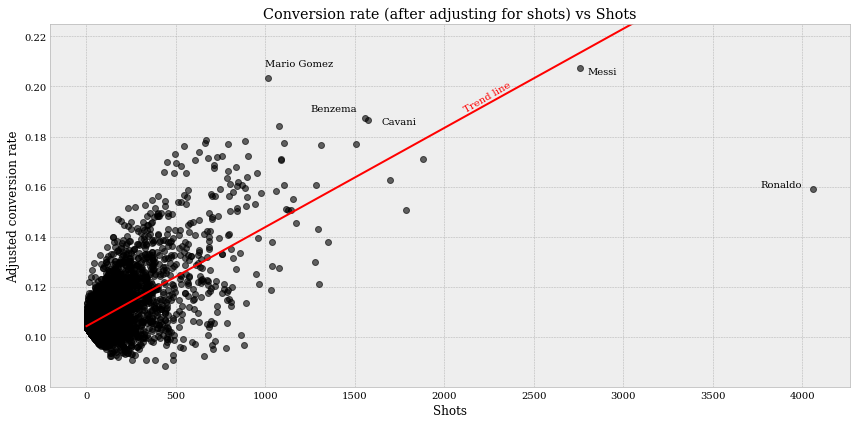

In [14]:
# adjusted posterior conversion rates for all players
fig, ax = plt.subplots(figsize = (12, 6))
ax.set_title('Conversion rate (after adjusting for shots) vs Shots')
ax.set_ylabel('Adjusted conversion rate')
ax.set_xlabel('Shots')
ax.plot(data['Shots'], data['Adjusted Posterior Conversion Rate'], 'ko', alpha = 0.6)
ax.text(2800, 0.205, 'Messi', color = 'k')
ax.text(4000, 0.16, 'Ronaldo', color = 'k', horizontalalignment = 'right')
ax.text(1000, 0.208, 'Mario Gomez', color = 'k')
ax.text(1250, 0.19, 'Benzema', color = 'k')
ax.text(1650, 0.185, 'Cavani', color = 'k')
ax.text(2100, 0.20, 'Trend line', color = 'r', rotation = 30)
z = np.polyfit(data['Shots'], data['Adjusted Posterior Conversion Rate'], 1)
p = np.poly1d(z)
ax.plot(data['Shots'], p(data['Shots']), 'r')
ax.set_ylim([0.08, 0.225])
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
fig.tight_layout()

#### Classifying players as elite finishers by controlling for false discovery rate and visualizaing the results:

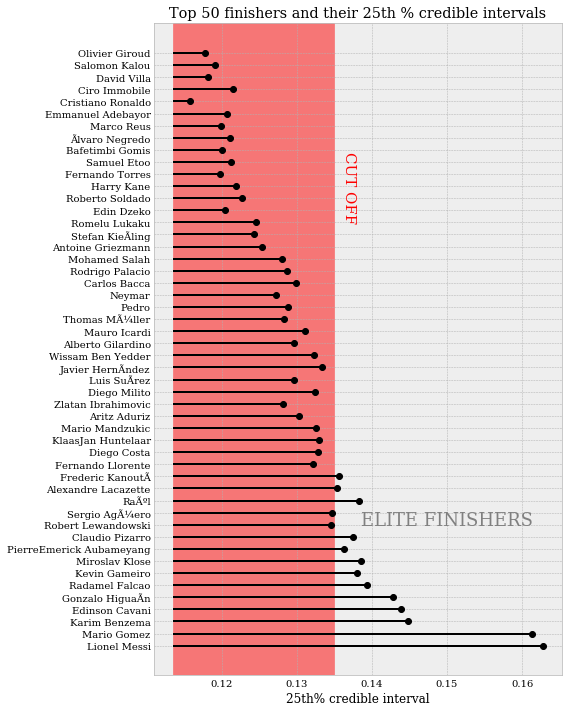

In [15]:
# false discovery rate control
best_finishers = data.sort_values('Adjusted Posterior Conversion Rate', ascending = False)[0: 50]
fig, ax = plt.subplots(figsize = (8, 10))
ax.set_title('Top 50 finishers and their 25th % credible intervals')
ax.set_xlabel('25th% credible interval')
ax.plot(best_finishers['Cred 0.025th'], best_finishers['Player'], 'ko')
ax.hlines(y = range(0, 50), xmin = ax.get_xlim()[0], xmax = best_finishers['Cred 0.025th'], color = 'k')
ax.axvspan(0.1135, 0.135, alpha = 0.5, color = 'red')
ax.text(0.136, 40, 'CUT OFF', color = 'red', fontsize = 15, rotation = 270)
ax.text(0.15, 10, 'ELITE FINISHERS', color = 'grey', fontsize = 18, horizontalalignment = 'center')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
fig.tight_layout()

#### Conclusion: Messi, Gomez, Benzema, Cavani and Higuain are the top 5 finishers in the last 12 years.